<a href="https://colab.research.google.com/github/WilliamQin65/cap-comp215/blob/main/SIR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SIR Project**

William Qin

Date: 2023-04-22

Description: This is a 2D Cellular Automata SIR model. It is an experiment to look at the potential effect of one policy on the spread of infection and number of infected cells. 

I get the idea from this article: https://towardsdatascience.com/simulating-covid-19-with-cellular-automata-aeb820910a9 

I use the code from the forest fire model and with the animation code.

In [7]:
%matplotlib inline

import time
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [8]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [9]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [20]:
class SIRModel:
    """ 2D Cellular Automaton that simulates the spread of an infectious disease using the SIR model """

    # Define names for the 3 possible cell states
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(0, 1, 0), (1, 0, 0), (0, 0, 1)]
    cmap[SUSCEPTIBLE] = (0, 1, 0)  # green
    cmap[INFECTED] = (1, 0, 0)  # red
    cmap[REMOVED] = (0, 0, 1)  # blue
    sir_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, p=0.01, i=0.01, r=0, ir=0.5, rr=0.1):
        """Initializes the model.
        n: number of rows
        p: initial proportion of cells that are susceptible
        i: initial proportion of cells that are infected
        r: initial proportion of cells that are removed (immune or deceased)
        ir: infection rate (probability that an infected cell infects one of its susceptible neighbors)
        rr: recovery rate (probability that an infected cell becomes removed)
        """
        self.n = n
        self.p = p
        self.i = i
        self.r = r
        self.ir = ir
        self.rr = rr
        # initialize landscape with initial proportions of each cell state
        self.array = np.zeros((n, n), dtype=int)
        self.array[np.random.random((n, n)) < p] = self.SUSCEPTIBLE
        self.array[np.random.random((n, n)) < i] = self.INFECTED
        self.array[np.random.random((n, n)) < r] = self.REMOVED

    def step(self):
        """Executes one time step, applying the CA rules to simulate the spread of the disease.
        """
        # TODO: define the rules for the CA.
        susceptible = self.array == self.SUSCEPTIBLE
        infected = self.array == self.INFECTED
        removed = self.array == self.REMOVED

        # step 1: An infected cell infects each of its susceptible neighbors with probability infection rate.
        neighbor_sum = correlate2d(infected, self.kernel, mode='same', boundary='wrap')
        infections = np.random.random(self.array.shape) < (self.ir * neighbor_sum) * susceptible
        self.array[infections] = self.INFECTED
        # step 2: An infected cell becomes removed with probability recovery rate.
        recoveries = np.random.random(self.array.shape) < self.rr * infected
        self.array[recoveries] = self.REMOVED

    def num_infected(self):
        """ return the number of cells infected """
        return np.sum(self.array == self.INFECTED)

    def pct_infected(self):
        """ return the proportion of cells infected """
        return self.num_infected() / self.array.size

    def draw(self, axes=None, step=''):
        """Draws the CA cells."""
        axes = axes or plt.axes
        title = f'Time:{step} Infected: {round(self.pct_infected() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.sir_colour_map, vmin=0, vmax=len(self.sir_colour_map.colors))

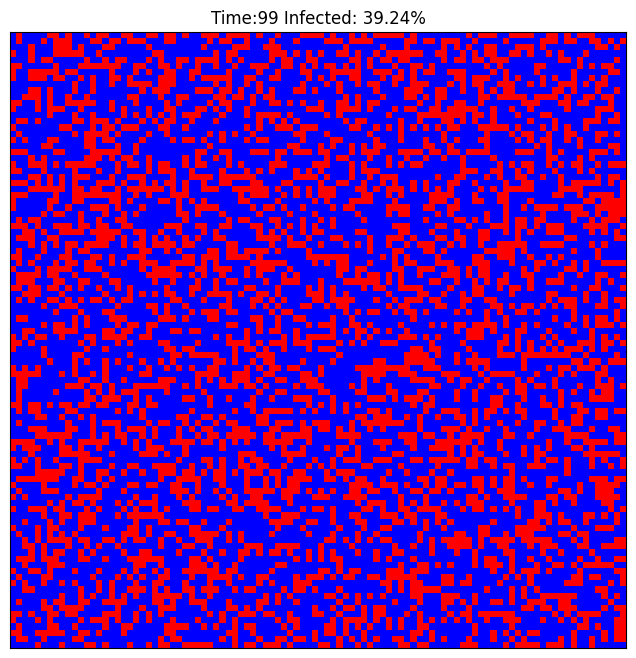

In [24]:
sir = SIRModel(100,0.01,0.01,0,0.5,0.01)
Animation = Animation2D(sir,frames = 100, steps_per_frame = 1)
Animation.animate(0.3)